In this notebook, you can find an interface to my code for BBM418 Assignment 3: "Image Classification with Convolutional Neural Networks" <br/>

Check report PDF for better text based explanation and proper answers to questions.

In [3]:
import warnings
from torchinfo import summary
from torchvision import transforms
from sklearn.metrics import accuracy_score
from kayla_tools import * # Importing all functions from my code

warnings.filterwarnings("ignore", category=UserWarning, module="torchinfo.torchinfo")
warnings.filterwarnings("ignore", category=UserWarning, module="torch.storage")

In [5]:
data_dir = os.path.join(os.getcwd(), "Micro_Organism") # Setting path to the dataset folder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Detected and using device: ", device)

Detected and using device:  cuda


Below is the code for processing the dataset. I had to resize it to fit them all in same structure, then I had to resize to 64x64 for better performance, sadly my computing power was not enough to train anything above. Also similarly in order to maximize performance while ensuring each class is represented in sets, I split dataset with a custom function that fills each set with minimum of 50 per clas for train and minimum of 20 for validation and test and rest goes to test data since it is the least performance impacting. The amount is: 400, 160, 229.

In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    transforms.ToTensor(),
])

train_data, valid_data, test_data = load_data(data_dir, transform)

train_set = BacteriaDataset(train_data, transform)
valid_set = BacteriaDataset(valid_data, transform)
test_set = BacteriaDataset(test_data, transform)

In [7]:
label_counts = {}

for _, label in train_data:
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

print("Count of each label in train set: ",label_counts)

Count of each label in train set:  {1: 50, 2: 50, 3: 50, 6: 50, 0: 50, 4: 50, 5: 50, 7: 50}


In [8]:
print("Size of train split: ",len(train_set))
print("Size of valid split: ",len(valid_set))
print("Size of test split: ",len(test_set))

Size of train split:  400
Size of valid split:  160
Size of test split:  229


Part 1 - Modeling and Training a CNN classifier from Scratch<br>

I will be defining the two models according to the paper. However I am going to also add ReLU layer for activation function (it was not stated in the paper) because without it the model would be a simple linear regression model. So I add ReLU to introduce non-linearity in the model and prevent the vanishing gradient. The details as follow:

Architecture:
- Conv2d layer with 32 output channels, kernel size 3, stride 1, padding 1
- ReLU activation function
- MaxPool2d layer with kernel size 2, stride 2
- Conv2d layer with 64 output channels, kernel size 3, stride 1, padding 1
- ReLU activation function
- Conv2d layer with 128 output channels, kernel size 3, stride 1, padding 1
- ReLU activation function
- Conv2d layer with 256 output channels, kernel size 3, stride 1, padding 1
- ReLU activation function
- Conv2d layer with 512 output channels, kernel size 3, stride 1, padding 1
- ReLU activation function
- Conv2d layer with 1024 output channels, kernel size 3, stride 1, padding 1
- ReLU activation function
- Flatten layer
- Linear layer with 1024 input features and 8 output features

Activation function: ReLU <br>
Loss function: CrossEntropyLoss<br>
Optimization algorithm: Adam

In [9]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, 3, 1, 1),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3, 1, 1),
    nn.ReLU(),
    nn.Conv2d(128, 256, 3, 1, 1),
    nn.ReLU(),
    nn.Conv2d(256, 512, 3, 1, 1),
    nn.ReLU(),
    nn.Conv2d(512, 1024, 3, 1, 1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(1024 * 32 * 32, 8)
)

In [10]:
summary(model, input_size=(16, 3, 64, 64), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 8]                   --
├─Conv2d: 1-1                            [16, 32, 64, 64]          896
├─ReLU: 1-2                              [16, 32, 64, 64]          --
├─MaxPool2d: 1-3                         [16, 32, 32, 32]          --
├─Conv2d: 1-4                            [16, 64, 32, 32]          18,496
├─ReLU: 1-5                              [16, 64, 32, 32]          --
├─Conv2d: 1-6                            [16, 128, 32, 32]         73,856
├─ReLU: 1-7                              [16, 128, 32, 32]         --
├─Conv2d: 1-8                            [16, 256, 32, 32]         295,168
├─ReLU: 1-9                              [16, 256, 32, 32]         --
├─Conv2d: 1-10                           [16, 512, 32, 32]         1,180,160
├─ReLU: 1-11                             [16, 512, 32, 32]         --
├─Conv2d: 1-12                           [16, 1024, 32, 32]     

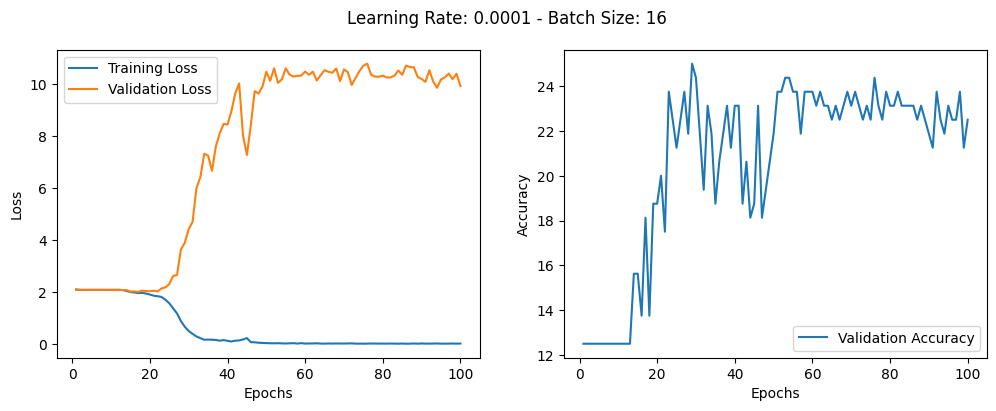

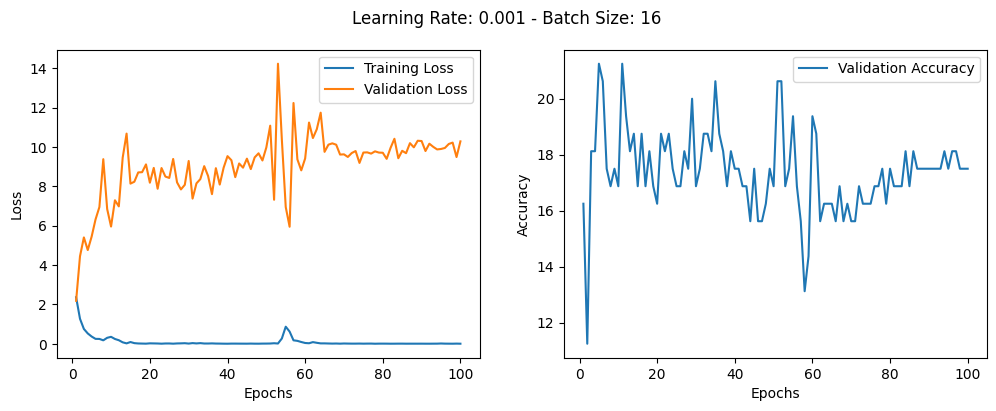

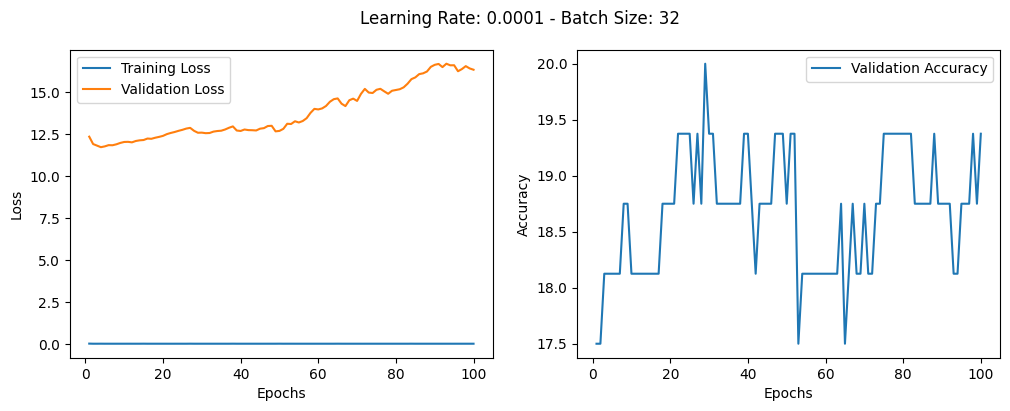

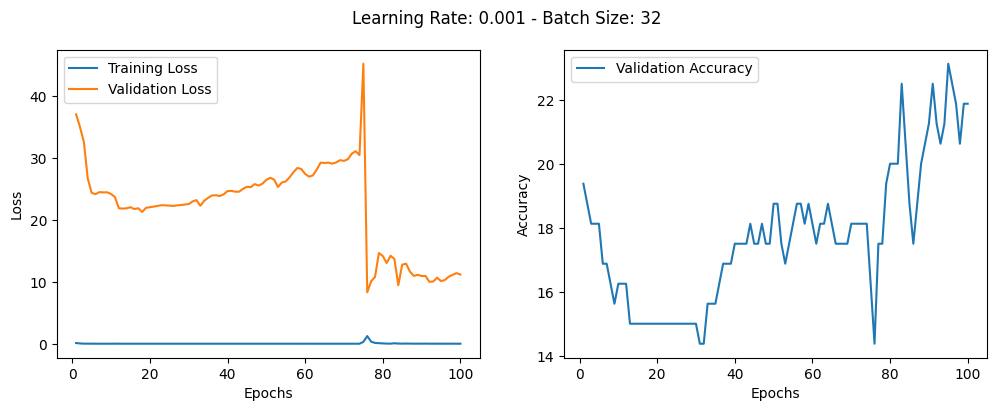

In [11]:
# Setting learning rates and batch sizes to run, I could test only these values as higher batch size wouldn't fit my GPU etc.
learning_rates = [0.0001, 0.001]
batch_sizes = [16, 32]
best_model, best_model_info = run_experiments(model, learning_rates, batch_sizes, train_set, valid_set, device)

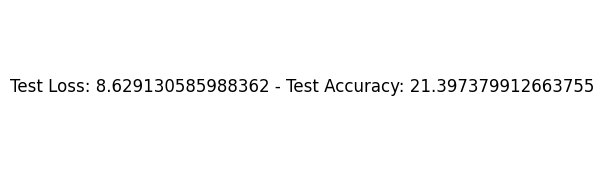

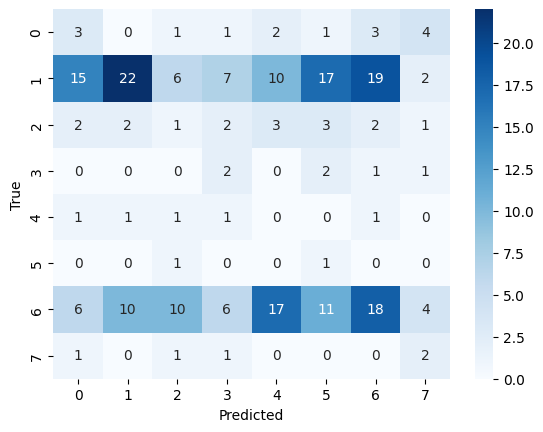

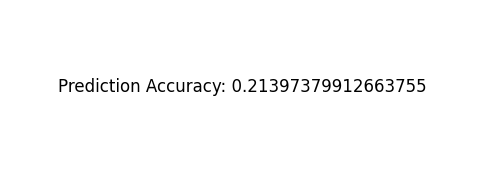

In [12]:
# Evaluating best model and plotting the best model test results
test_loader = DataLoader(test_set, batch_size=best_model_info["bs"], shuffle=False)
test_loss, test_accuracy = evaluate(best_model, nn.CrossEntropyLoss(), test_loader, device)
plot_text(f"Test Loss: {test_loss} - Test Accuracy: {test_accuracy}")

labels = list(range(8))
y_true, y_pred = get_predictions(best_model, test_loader, device)
plot_confusion_matrix(y_true, y_pred, labels)
accuracy = accuracy_score(y_true, y_pred)

plot_text(f"Prediction Accuracy: {accuracy}")

In [13]:
def addDropOutModel(modelState, dropout_value):
    # To create drop out model, I add drop out after first ReLU
    # I got this information from the referenced source: [4] Stack Exchange. "Where should I place dropout layers in a neural network?". Retrieved May 11, 2023 from: https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network
    # However after seeing results, it seemed the position was wrong and the values that tested were too high.
    dropModel = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=dropout_value),
        nn.Conv2d(32, 64, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(64, 128, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(128, 256, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(256, 512, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(512, 1024, 3, 1, 1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1024 * 32 * 32, 8)
    )

    # In this part, I tried to transfer the data from the previous model to drop out model
    # Load the pretrained weights into the modified model
    pretrained_dict = modelState
    modified_dict = dropModel.state_dict()
    processed = [];
    # Maping the corresponding keys and update the modified model's state dictionary
    for key in modified_dict.keys():
        if key in pretrained_dict:
            processed.append(key)
            modified_dict[key] = pretrained_dict[key]
        elif key not in processed and str(int(key.split(".")[0])-1)+"."+key.split(".")[1] in pretrained_dict:
             processed.append(key)
             modified_dict[key] = pretrained_dict[str(int(key.split(".")[0])-1)+"."+key.split(".")[1]]
        else:
            print("Can not find key pair for: ", key)

    dropModel.load_state_dict(modified_dict)

    return dropModel

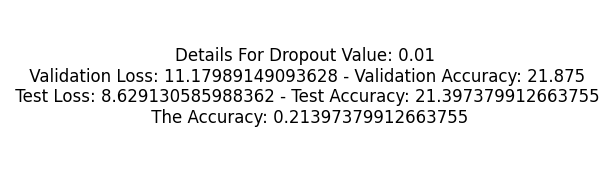

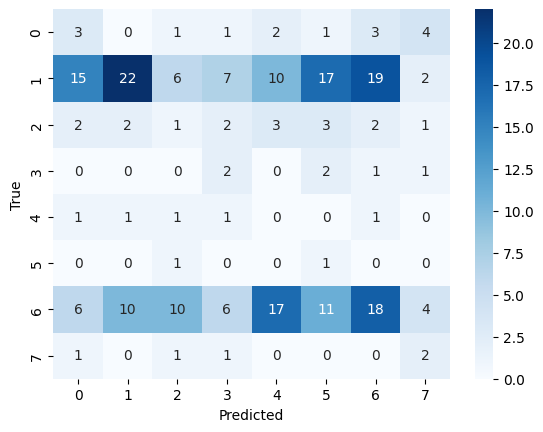

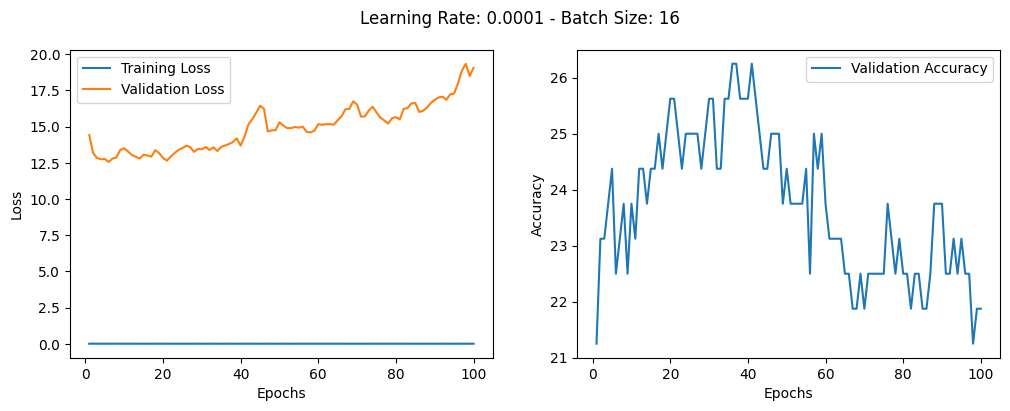

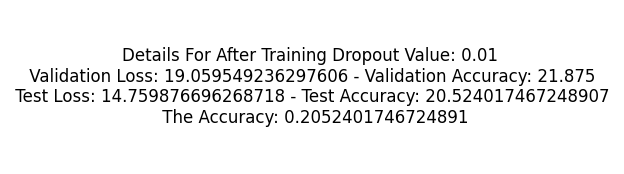

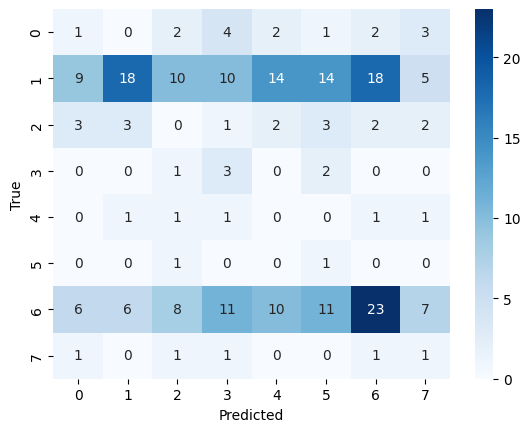

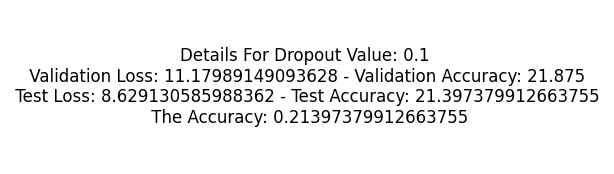

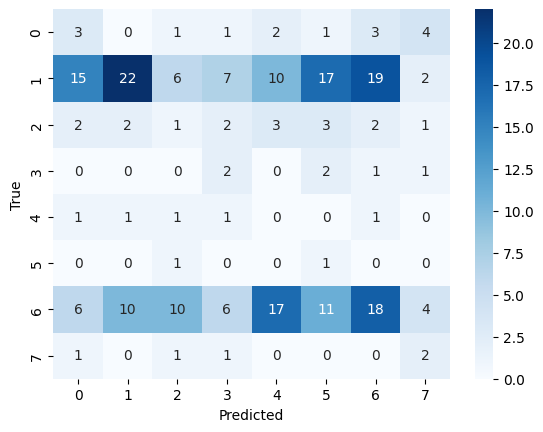

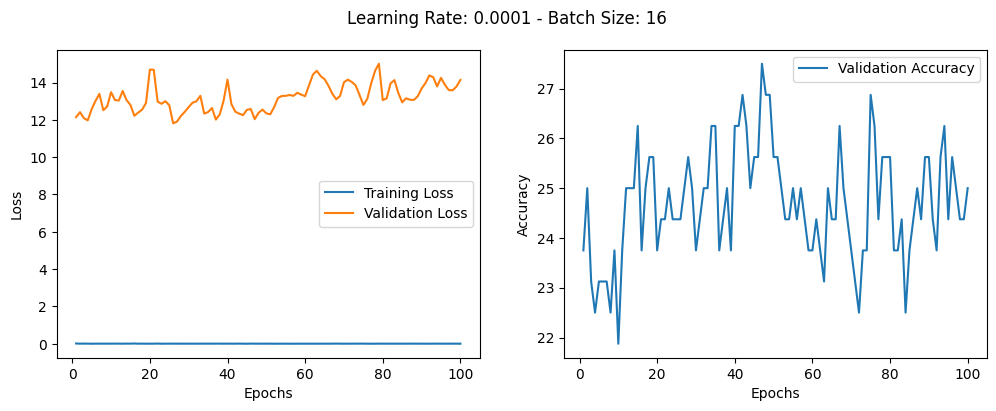

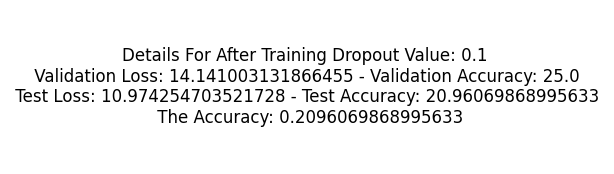

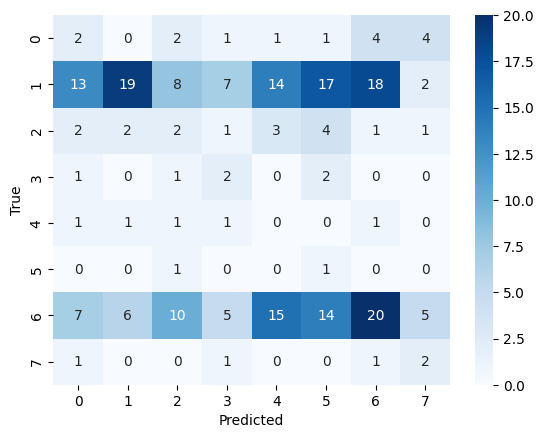

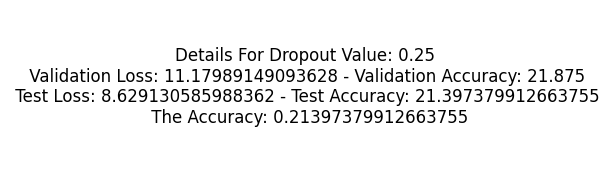

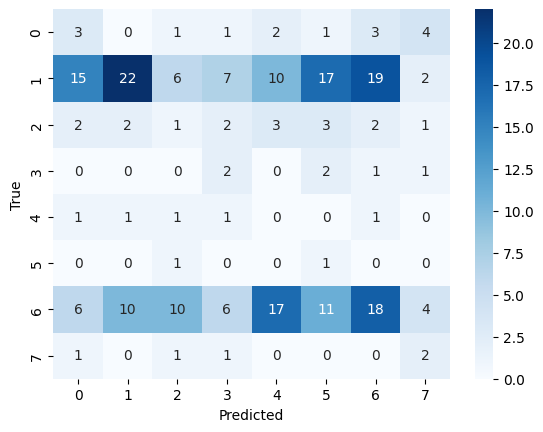

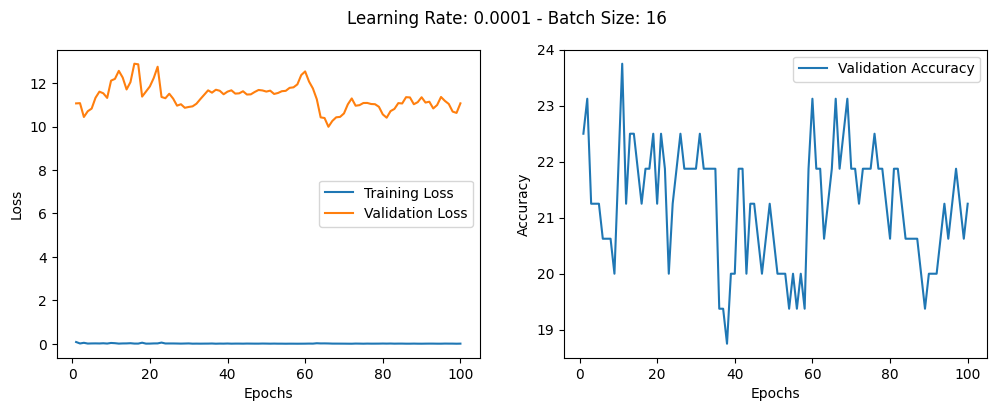

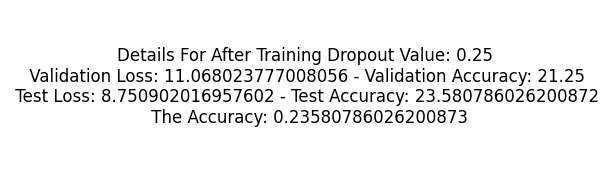

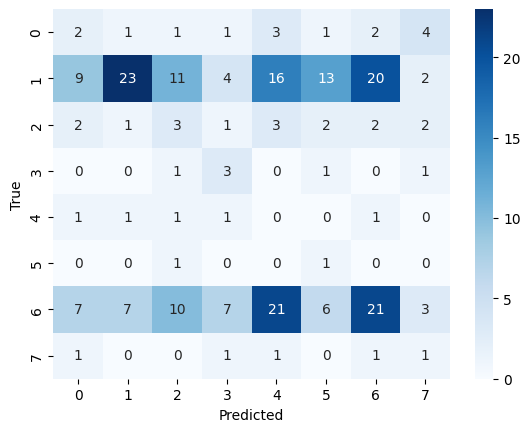

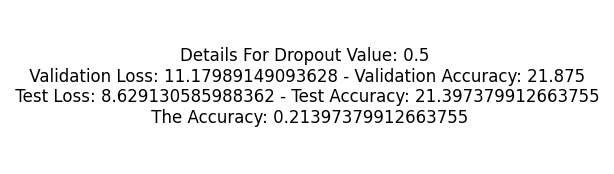

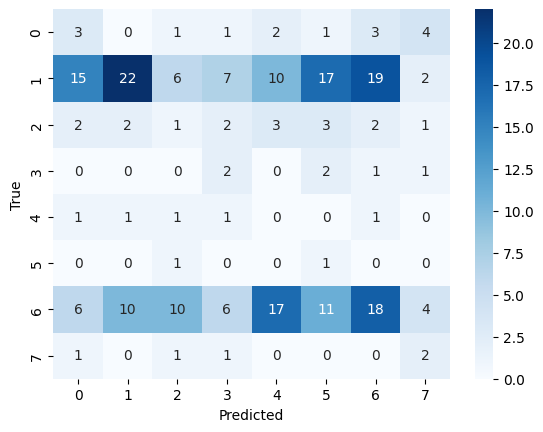

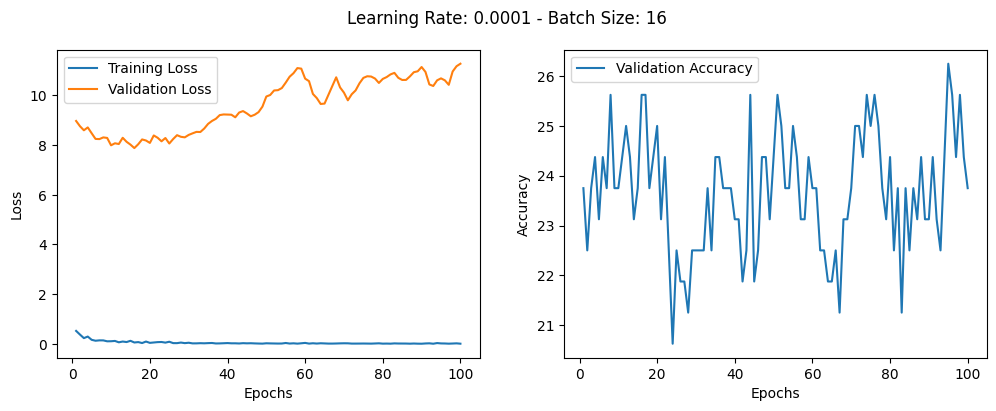

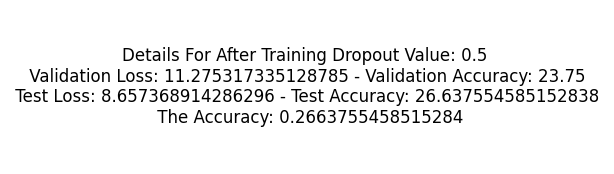

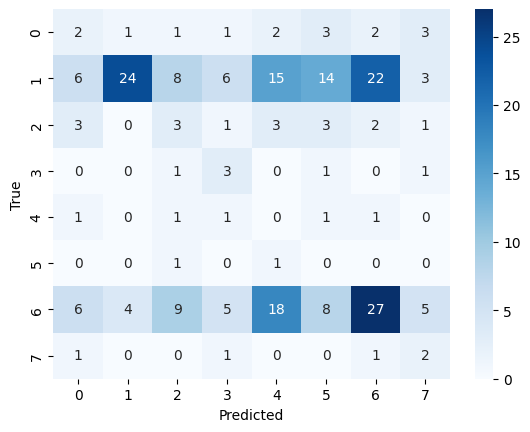

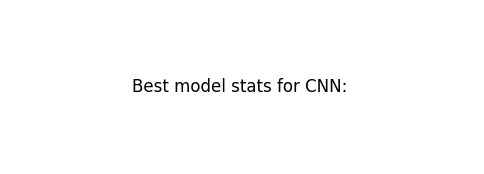

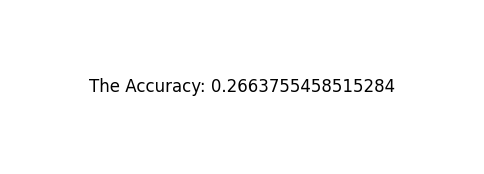

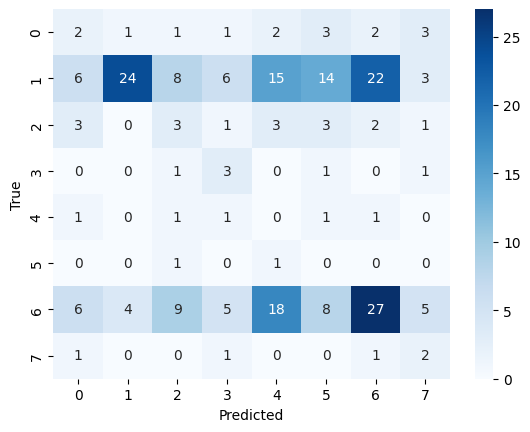

In [14]:
dropout_rates = [0.01, 0.1, 0.25, 0.5] # The tested value is [0.01, 0.1, 0.25, 0.5]

best_y_true, best_y_pred = [], []
best_acc = 0
labels = list(range(8))
for dr in dropout_rates:
    model_with_dropout = addDropOutModel(best_model_info["state_dict"], dr) # Convert best model to drop out model
    model_with_dropout.to(device) # Send model to device
    # Evaluate the model on the validation and test sets
    valid_loader = DataLoader(valid_set, batch_size=best_model_info["bs"], shuffle=False)
    valid_loss, valid_acc = evaluate(model_with_dropout, nn.CrossEntropyLoss(), valid_loader, device)
    
    test_loader = DataLoader(test_set, batch_size=best_model_info["bs"], shuffle=False)
    test_loss, test_acc = evaluate(model_with_dropout, nn.CrossEntropyLoss(), test_loader, device)
    
    y_true, y_pred = get_predictions(model_with_dropout, test_loader, device)
    # Plotting results
    accuracy = accuracy_score(y_true, y_pred)
    if accuracy > best_acc:
      best_y_true, best_y_pred = y_true, y_pred
      best_acc = accuracy
    plot_text(f"Details For Dropout Value: {dr} \n Validation Loss: {valid_loss} - Validation Accuracy: {valid_acc} \n Test Loss: {test_loss} - Test Accuracy: {test_acc} \n The Accuracy: {accuracy}")
    plot_confusion_matrix(y_true, y_pred, labels)

    learning_rates = [best_model_info["lr"]]
    batch_sizes = [best_model_info["bs"]]
    temp_model, temp_model_info = run_experiments(model_with_dropout, learning_rates, batch_sizes, train_set, valid_set, device)

    valid_loss, valid_acc = evaluate(model_with_dropout, nn.CrossEntropyLoss(), valid_loader, device)
    
    test_loss, test_acc = evaluate(model_with_dropout, nn.CrossEntropyLoss(), test_loader, device)
    
    y_true, y_pred = get_predictions(model_with_dropout, test_loader, device)
    # Plotting results
    accuracy = accuracy_score(y_true, y_pred)
    if accuracy > best_acc:
      best_y_true, best_y_pred = y_true, y_pred
      best_acc = accuracy
    plot_text(f"Details For After Training Dropout Value: {dr} \n Validation Loss: {valid_loss} - Validation Accuracy: {valid_acc} \n Test Loss: {test_loss} - Test Accuracy: {test_acc} \n The Accuracy: {accuracy}")
    plot_confusion_matrix(y_true, y_pred, labels)

plot_text(f"Best model stats for CNN: ")
plot_text(f"The Accuracy: {best_acc}")
plot_confusion_matrix(best_y_true, best_y_pred, labels)

For the ResNet model I used class structure to easly configure residual blocks. You can check the code for the implementation. Here is the model details:

Architecture:
- Conv2d layer with 32 output channels, kernel size 3, stride 1, padding 1
- BatchNorm2d layer with 32 input channels
- ReLU activation function
- 5 Residual blocks, each with:
- Two Conv2d layers with kernel size 3, stride depending on the block, padding 1
- Two BatchNorm2d layers
- ReLU activation function
- A shortcut connection
- Flatten layer
- Linear layer with 1024 input features and 8 output features

Activation function: ReLU<br>
Loss function: CrossEntropyLoss<br>
Optimization algorithm: Adam

In [15]:
model_with_residual = ResNet()

In [16]:
summary(model_with_residual, input_size=(16, 3, 64, 64), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 8]                   --
├─Conv2d: 1-1                            [16, 32, 64, 64]          896
├─BatchNorm2d: 1-2                       [16, 32, 64, 64]          64
├─ReLU: 1-3                              [16, 32, 64, 64]          --
├─MaxPool2d: 1-4                         [16, 32, 32, 32]          --
├─Sequential: 1-5                        [16, 64, 32, 32]          --
│    └─ResidualBlock: 2-1                [16, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                  [16, 64, 32, 32]          18,496
│    │    └─BatchNorm2d: 3-2             [16, 64, 32, 32]          128
│    │    └─ReLU: 3-3                    [16, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                  [16, 64, 32, 32]          36,928
│    │    └─BatchNorm2d: 3-5             [16, 64, 32, 32]          128
│    │    └─Sequential: 3-6              [16, 64, 32, 32]          2,240
│

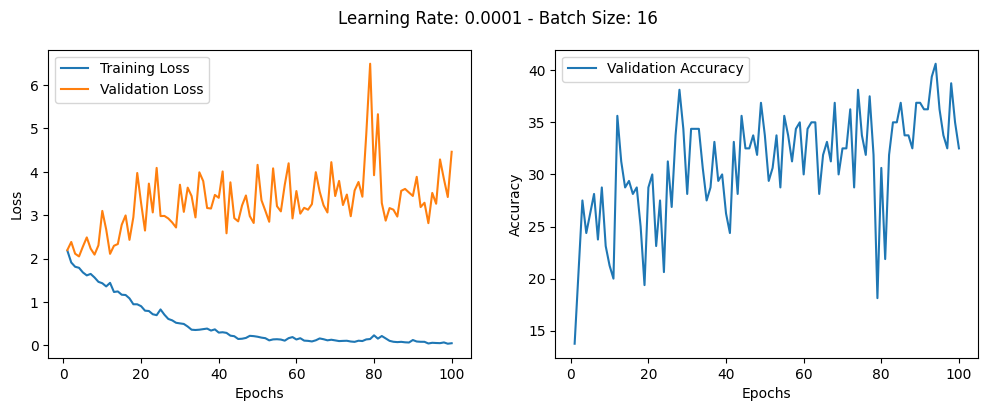

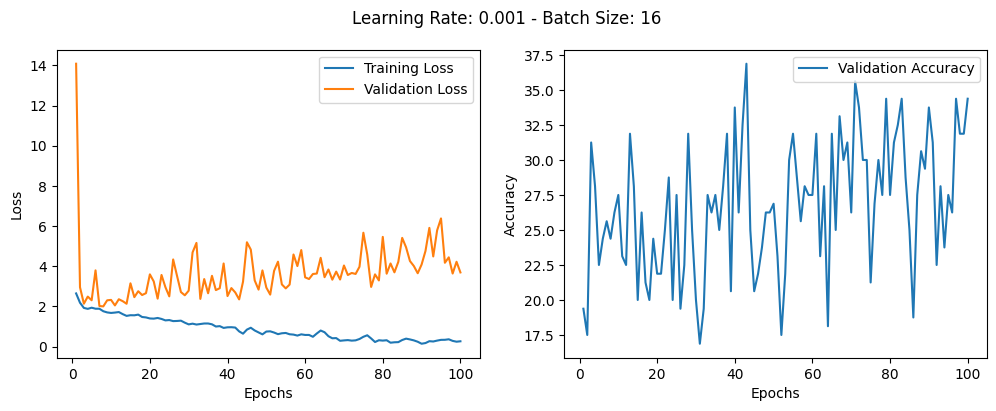

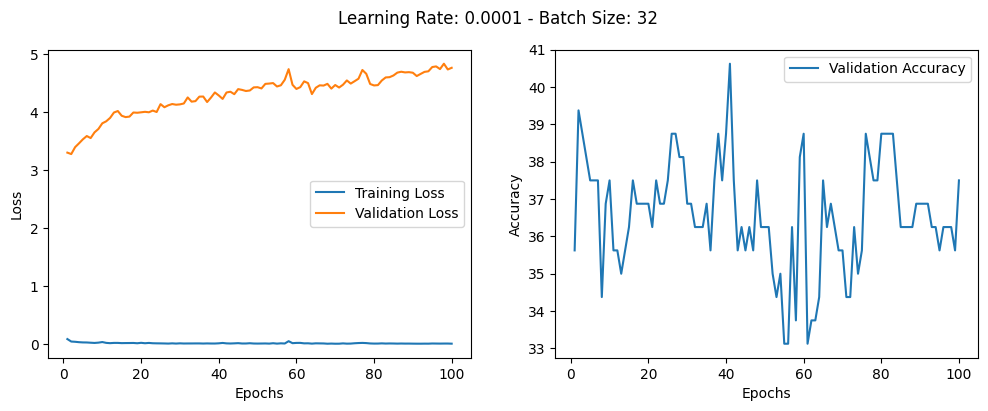

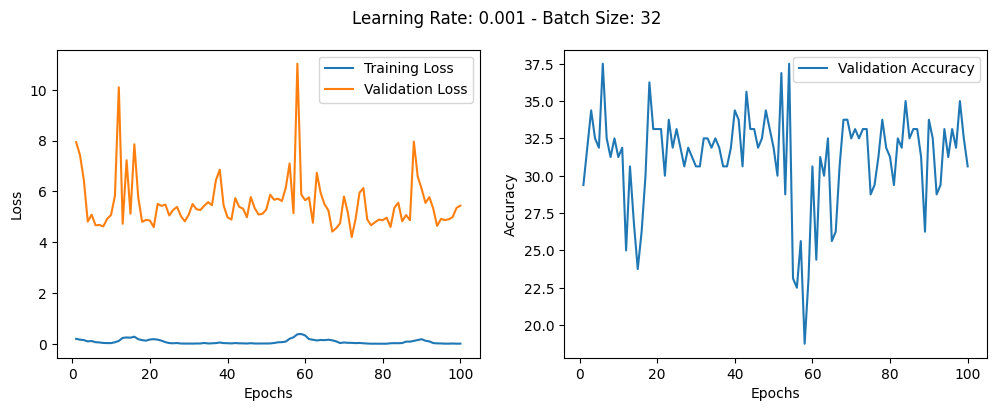

In [17]:
# Calling the function with two learning rates and batch sizes
learning_rates = [0.0001, 0.001]
batch_sizes = [16, 32]
best_model, best_model_info = run_experiments(model_with_residual, learning_rates, batch_sizes, train_set, valid_set, device)

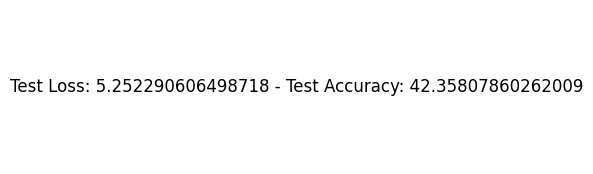

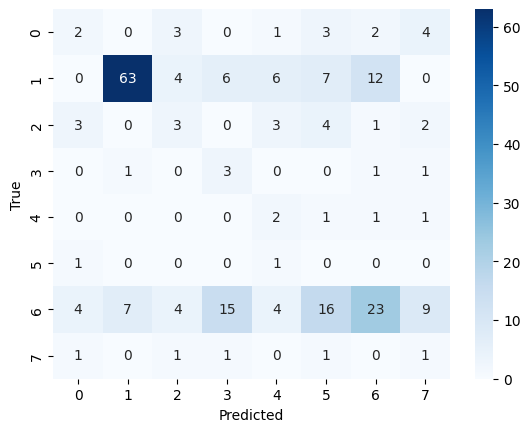

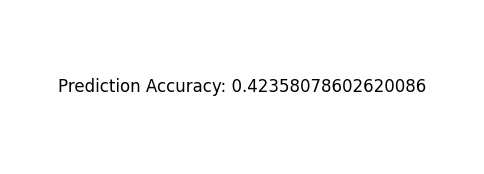

In [18]:
# Evaluating best model and plotting the best model test results
test_loader = DataLoader(test_set, batch_size=best_model_info["bs"], shuffle=False)
test_loss, test_accuracy = evaluate(best_model, nn.CrossEntropyLoss(), test_loader, device)
plot_text(f"Test Loss: {test_loss} - Test Accuracy: {test_accuracy}")

labels = list(range(8))
y_true, y_pred = get_predictions(best_model, test_loader, device)
plot_confusion_matrix(y_true, y_pred, labels)
accuracy = accuracy_score(y_true, y_pred)

plot_text(f"Prediction Accuracy: {accuracy}")

In [19]:
def ResnetModelMerge(trained_resnet_model_state, resnet_model):
    # Merging the model, in other words copying the trained weights of first model to new model with drop out values
    pretrained_dict = trained_resnet_model_state
    modified_dict = resnet_model.state_dict()
    processed = [];
    # Maping the corresponding keys and update the modified model's state dictionary
    for key in modified_dict.keys():
        if key in pretrained_dict:
            processed.append(key)
            modified_dict[key] = pretrained_dict[key]
        elif key not in processed and str(int(key.split(".")[0])-1)+"."+key.split(".")[1] in pretrained_dict:
             processed.append(key)
             modified_dict[key] = pretrained_dict[str(int(key.split(".")[0])-1)+"."+key.split(".")[1]]
        else:
            print("Can not find key pair for: ", key)

    resnet_model.load_state_dict(modified_dict)

    return resnet_model

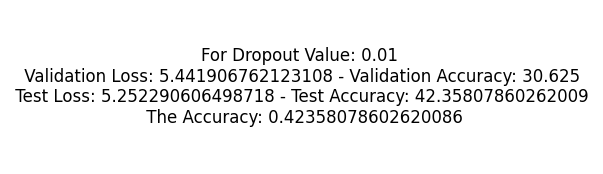

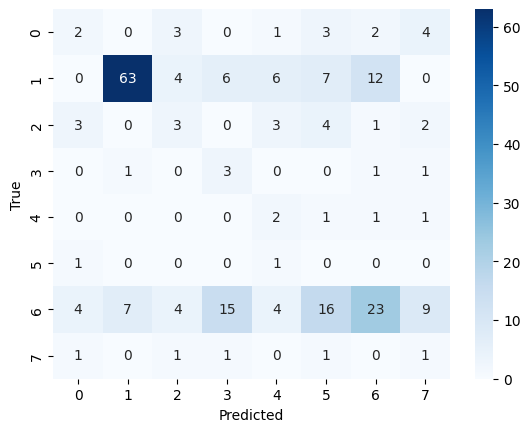

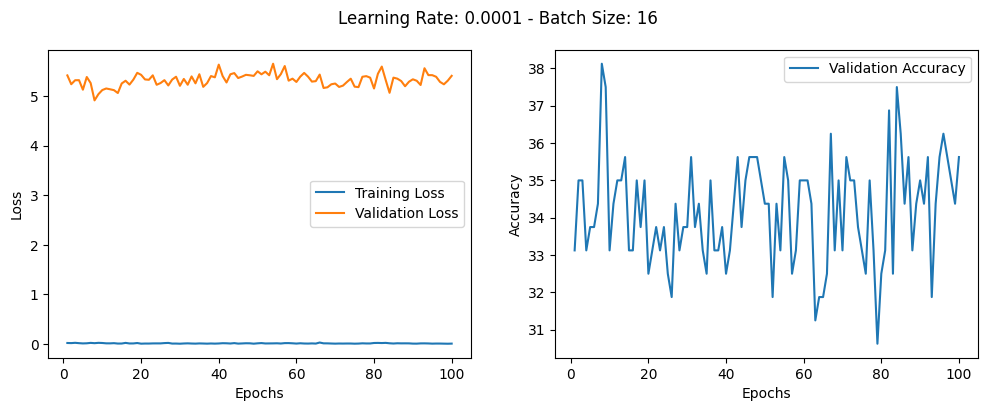

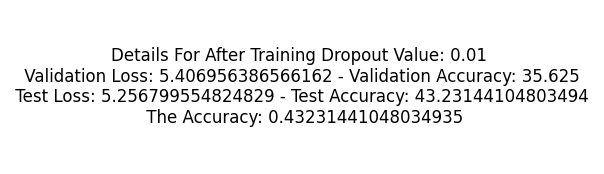

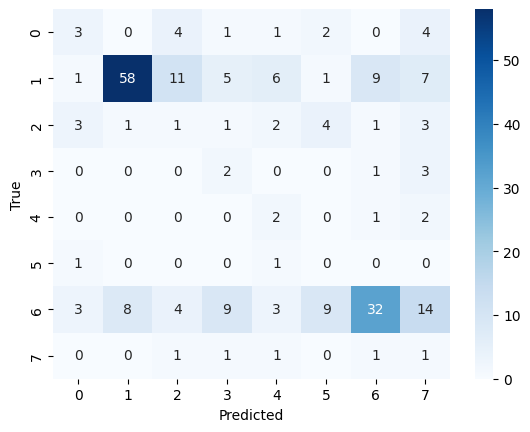

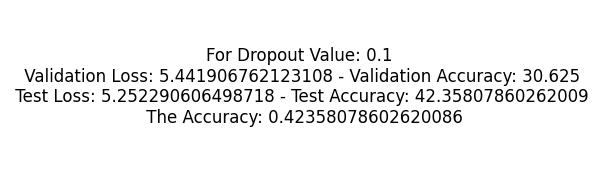

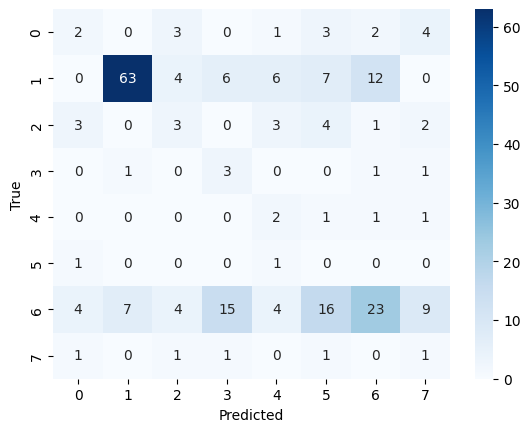

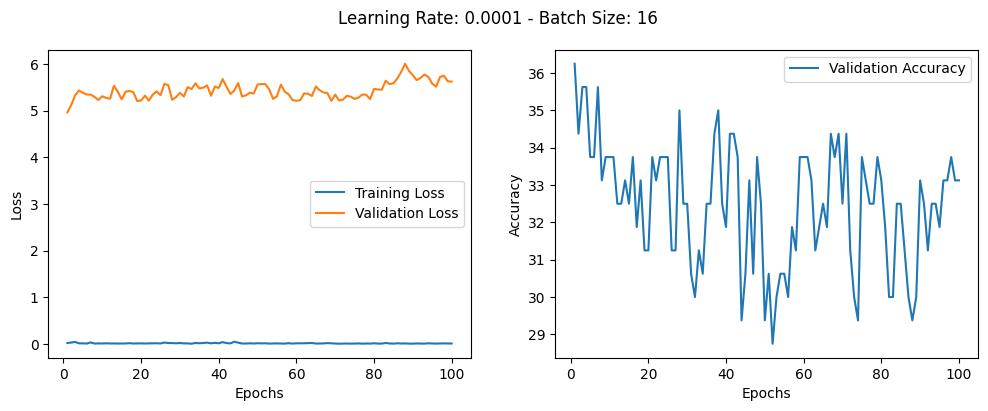

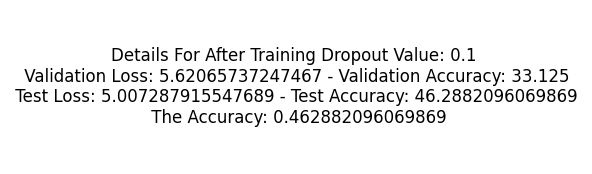

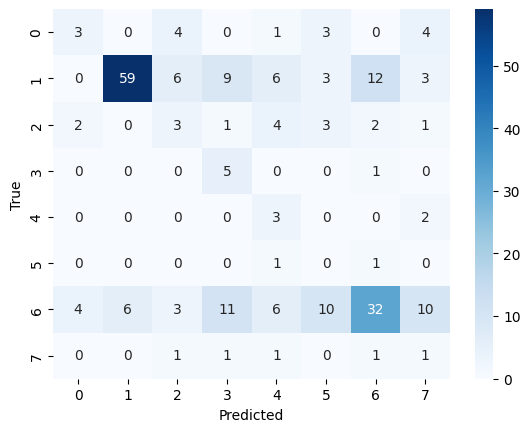

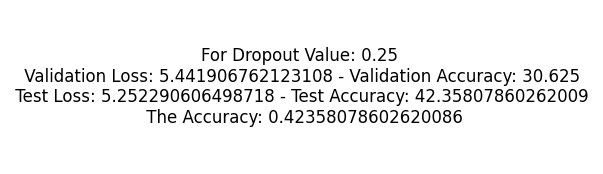

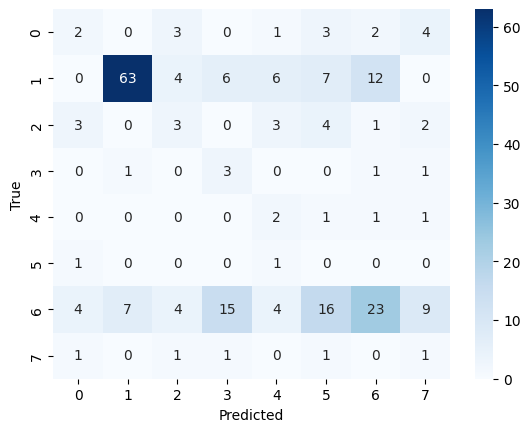

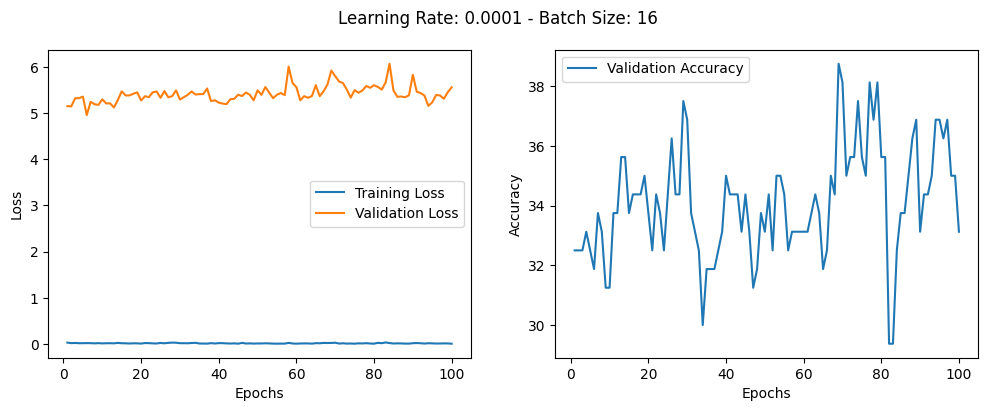

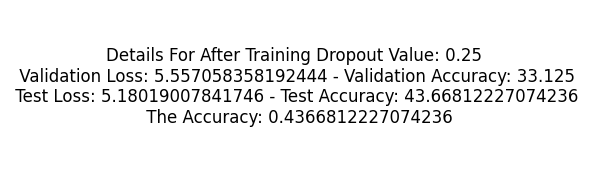

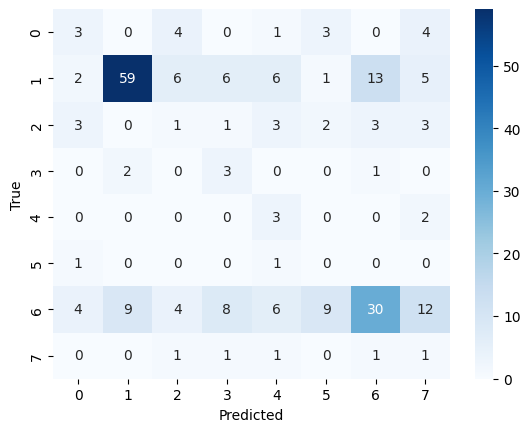

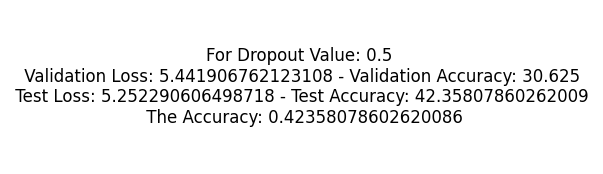

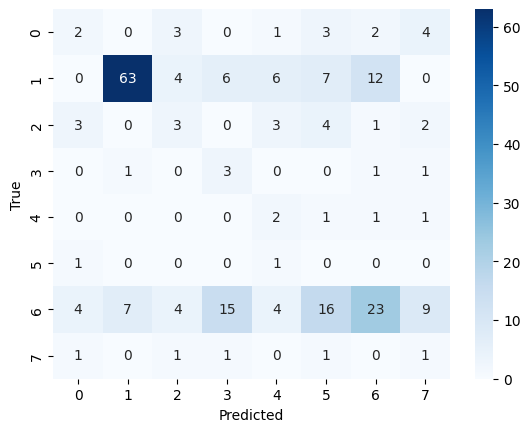

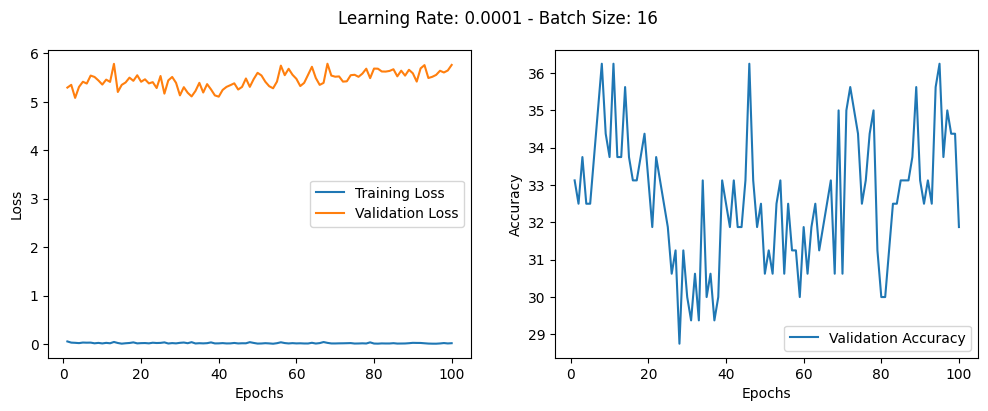

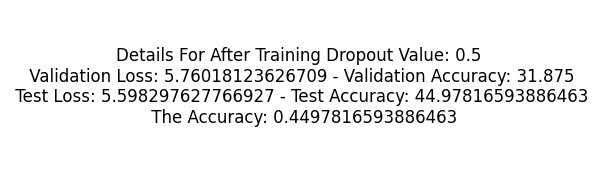

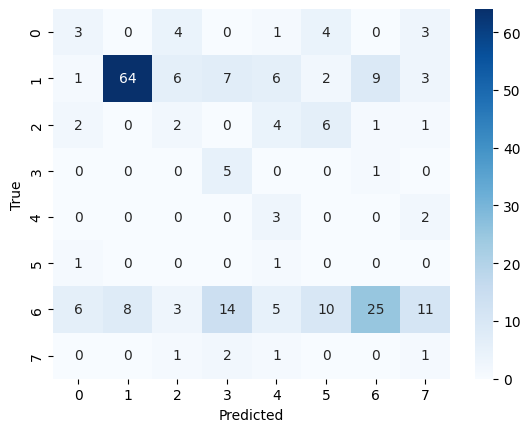

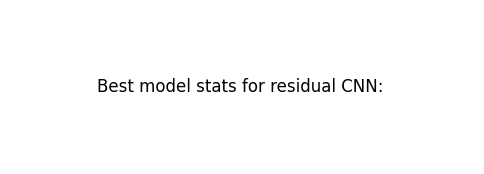

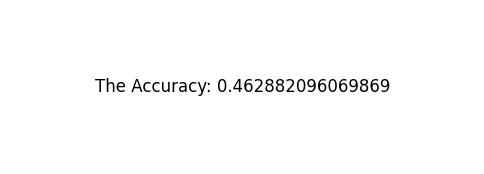

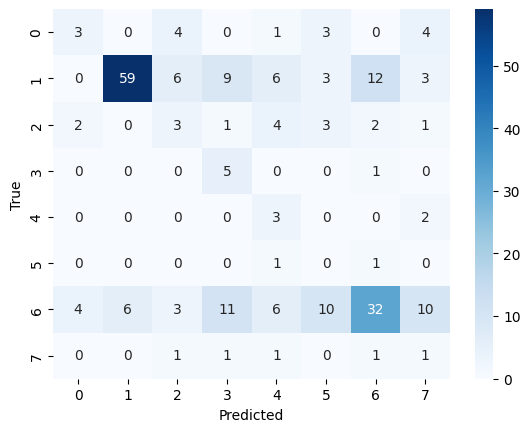

In [20]:
dropout_rates = [0.01, 0.1, 0.25, 0.5] # Tested values [0.01, 0.1, 0.25, 0.5]

best_y_true, best_y_pred = [], []
best_acc = 0
labels = list(range(8))
for dr in dropout_rates:
    model_with_residual_dropout = ResNetDropout(dropout_value = dr); # Creating a new residual model with drop out layer with drop out value
    model_with_dropout = ResnetModelMerge(best_model_info["state_dict"], model_with_residual_dropout); # Merging the weights of previous model to new drop out model
    model_with_dropout.to(device) # Sending model to device
    # Evaluate the model on the validation and test sets
    valid_loader = DataLoader(valid_set, batch_size=best_model_info["bs"], shuffle=False)
    valid_loss, valid_acc = evaluate(model_with_dropout, nn.CrossEntropyLoss(), valid_loader, device)
    
    test_loader = DataLoader(test_set, batch_size=best_model_info["bs"], shuffle=False)
    test_loss, test_acc = evaluate(model_with_dropout, nn.CrossEntropyLoss(), test_loader, device)

    y_true, y_pred = get_predictions(model_with_dropout, test_loader, device)
    # Plotting results
    accuracy = accuracy_score(y_true, y_pred)
    if accuracy > best_acc:
      best_y_true, best_y_pred = y_true, y_pred
      best_acc = accuracy
    plot_text(f"For Dropout Value: {dr} \n Validation Loss: {valid_loss} - Validation Accuracy: {valid_acc} \n Test Loss: {test_loss} - Test Accuracy: {test_acc} \n The Accuracy: {accuracy}")
    plot_confusion_matrix(y_true, y_pred, labels)

    learning_rates = [best_model_info["lr"]]
    batch_sizes = [best_model_info["bs"]]
    temp_model, temp_model_info = run_experiments(model_with_dropout, learning_rates, batch_sizes, train_set, valid_set, device)

    valid_loss, valid_acc = evaluate(model_with_dropout, nn.CrossEntropyLoss(), valid_loader, device)
    
    test_loss, test_acc = evaluate(model_with_dropout, nn.CrossEntropyLoss(), test_loader, device)
    
    y_true, y_pred = get_predictions(model_with_dropout, test_loader, device)
    # Plotting results
    accuracy = accuracy_score(y_true, y_pred)
    if accuracy > best_acc:
      best_y_true, best_y_pred = y_true, y_pred
      best_acc = accuracy
    plot_text(f"Details For After Training Dropout Value: {dr} \n Validation Loss: {valid_loss} - Validation Accuracy: {valid_acc} \n Test Loss: {test_loss} - Test Accuracy: {test_acc} \n The Accuracy: {accuracy}")
    plot_confusion_matrix(y_true, y_pred, labels)

plot_text(f"Best model stats for residual CNN: ")
plot_text(f"The Accuracy: {best_acc}")
plot_confusion_matrix(best_y_true, best_y_pred, labels)

Part 2 - Transfer Learning with CNNs

In [21]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

num_classes = 8 # Setting the num classes

onlyFCmodel is for the first case which is only FC layer, twoandFCmodel is for the second case which is FC layer and last two convolutional layer

In [22]:
# Load the pre-trained ResNet-18 model
onlyFCmodel = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all layers
for param in onlyFCmodel.parameters():
    param.requires_grad = False
# Unfreeze the last layer which is FC
for param in onlyFCmodel.fc.parameters():
    param.requires_grad = True
    
num_features = onlyFCmodel.fc.in_features
onlyFCmodel.fc = nn.Linear(num_features, num_classes) # Replace the last FC layer

onlyFCmodel = onlyFCmodel.to(device) # Move the model to the device

# Set up the criterion and optimizer
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(onlyFCmodel.fc.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 279MB/s]


In [23]:
# Load the pre-trained ResNet-18 model
twoandFCmodel = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all layers
for param in twoandFCmodel.parameters():
    param.requires_grad = False

# Unfreeze the last two convolutional layers
for name, param in twoandFCmodel.layer4.named_parameters():
    if 'layer4.0.conv1' in name or 'layer4.0.conv2' in name:
        param.requires_grad = True

num_features = twoandFCmodel.fc.in_features
twoandFCmodel.fc = nn.Linear(num_features, num_classes) # Replace the last FC layer

twoandFCmodel = twoandFCmodel.to(device) # Move the model to the device

# Set up the criterion and optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(
    [{"params": twoandFCmodel.layer4.parameters()},
     {"params": twoandFCmodel.fc.parameters()}], lr=0.001)

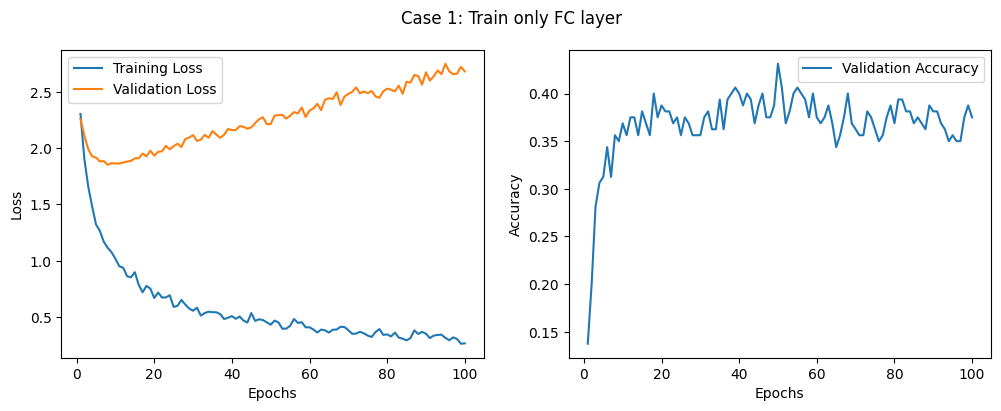

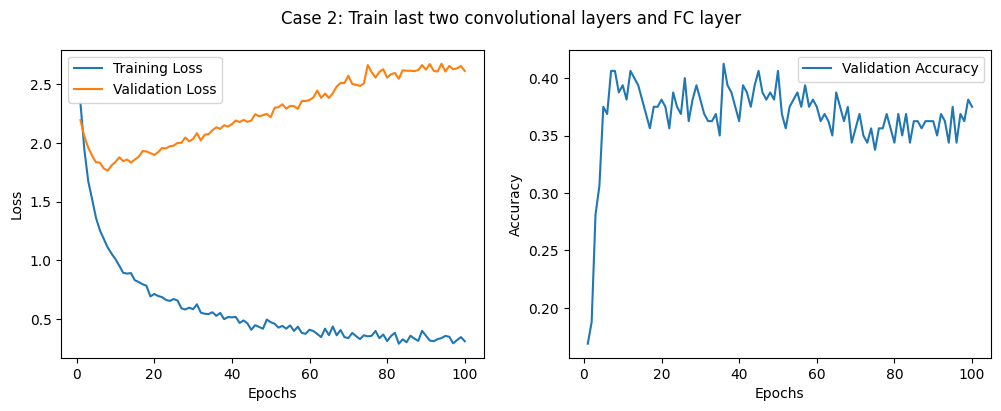

In [24]:
# Load data
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Train and evaluate the model
train_losses1, valid_losses1, valid_accuracies1 = train_and_evaluate(onlyFCmodel, optimizer1, criterion1, train_loader, valid_loader, device)
train_losses2, valid_losses2, valid_accuracies2 = train_and_evaluate(twoandFCmodel, optimizer2, criterion2, train_loader, valid_loader, device)

# Plot the results
plot(train_losses1, valid_losses1, valid_accuracies1, "Case 1: Train only FC layer")
plot(train_losses2, valid_losses2, valid_accuracies2, "Case 2: Train last two convolutional layers and FC layer")

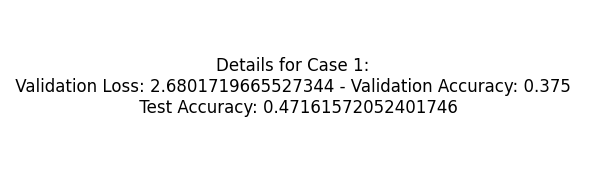

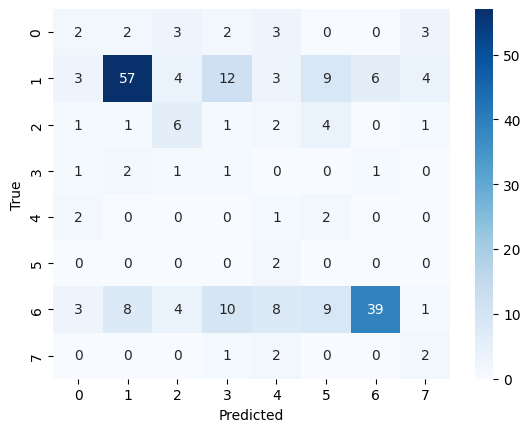

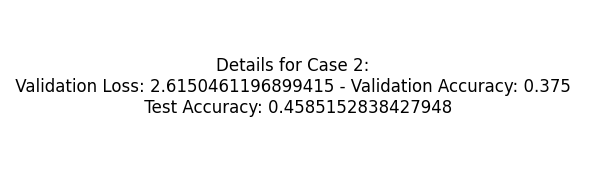

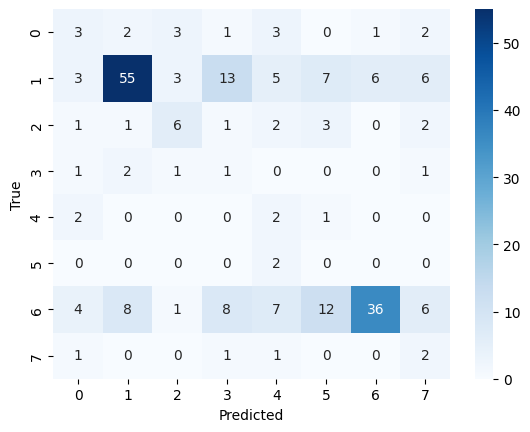

In [25]:
# Obtain predicted labels from the best model
onlyFCmodel.eval()
# After training and testing, get the true labels and predicted labels
y_true, y_pred = get_pred_part2(onlyFCmodel, test_loader, device)
accuracy1 = accuracy_score(y_true, y_pred)
# Call the function to plot the confusion matrix
plot_text(f"Details for Case 1: \n Validation Loss: {valid_losses1[len(valid_losses1)-1]} - Validation Accuracy: {valid_accuracies1[len(valid_accuracies1)-1]}  \n Test Accuracy: {accuracy1}")
plot_confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

# Obtain predicted labels from the best model
twoandFCmodel.eval()

# After training and testing, get the true labels and predicted labels
y_true, y_pred = get_pred_part2(twoandFCmodel, test_loader, device)

accuracy2 = accuracy_score(y_true, y_pred)
# Call the function to plot the confusion matrix
plot_text(f"Details for Case 2: \n Validation Loss: {valid_losses2[len(valid_losses2)-1]} - Validation Accuracy: {valid_accuracies2[len(valid_accuracies2)-1]}  \n Test Accuracy: {accuracy2}")
plot_confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

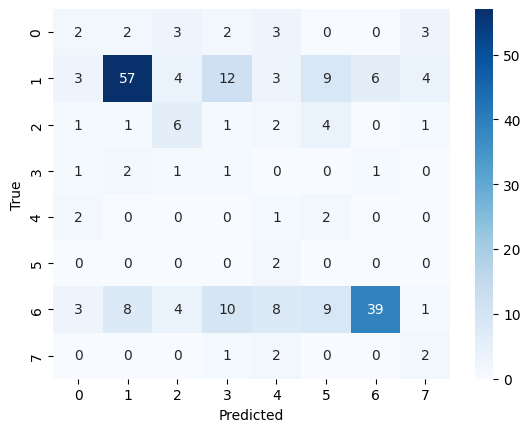

In [26]:
best_model = onlyFCmodel if max(valid_accuracies1) >= max(valid_accuracies2) else twoandFCmodel # Getting best model according to accuracy

# Obtain predicted labels from the best model
best_model.eval()
# After training and testing, get the true labels and predicted labels
y_true, y_pred = get_pred_part2(best_model, test_loader, device)

# Call the function to plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

Kayla Akyüz <br/>
21726914